In [1]:
base_path = "/content/drive/My Drive/Github/casbl-for-jadce-in-mtc"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')# Load saved data

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [4]:
!apt-get update
!apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 https://cli.github.com/packages stable InRelease
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [80.4 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,002 kB]
Get:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,791 kB]
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy/main amd64 Packages [43.0 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,2

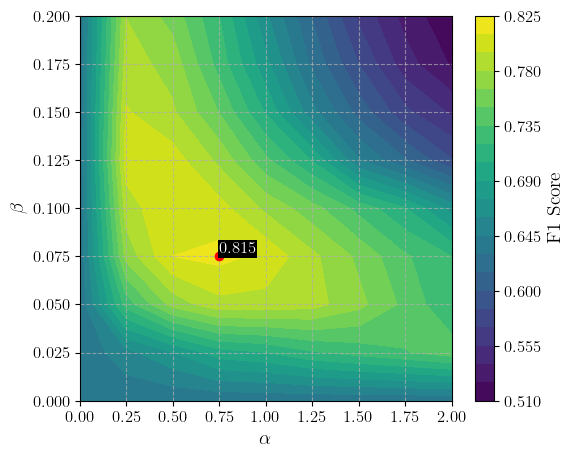

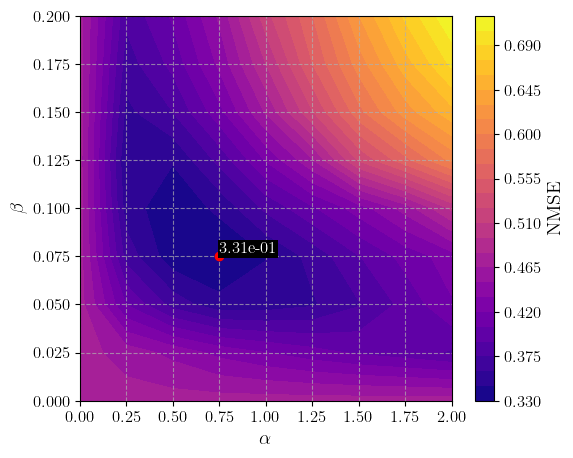

In [12]:
import re
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Config
# =========================
hp_folder = f"{base_path}/hyper_parameter_tuning/casbl/data"
fig_dir   = f"{base_path}/hyper_parameter_tuning/casbl/figures"

# List the exact files (β fixed per file, α varies within)
beta_nums = [0.000, 0.025, 0.050, 0.075, 0.100, 0.125, 0.150, 0.175, 0.200]
file_paths = [
    f"{hp_folder}/casbl_alpha_all_beta_{b:.3f}_snr_db_12_pilot_length_25.npz".replace('.', '_', 1)
    for b in beta_nums
]

alpha_values = np.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2], dtype=float)

# =========================
# Load ground truth
# =========================
all_gamma_true = np.load(f"{base_path}/communication_model/data/communication_simulation_gamma.npz",
                         allow_pickle=True)["all_gamma"]  # (S, N)
all_z_true     = np.load(f"{base_path}/communication_model/data/communication_simulation_z.npz",
                         allow_pickle=True)["all_z"]      # (S, N, M)

# =========================
# Helpers
# =========================
def parse_beta_from_filename(path):
    # finds "...beta_0_05..." -> 0.05
    m = re.search(r"beta_([0-9]+)_([0-9]+)", path)
    if not m: raise ValueError(f"Cannot parse beta from {path}")
    return float(f"{m.group(1)}.{m.group(2)}")

def gamma_object2bool(g_obj, tau=0.15):
    # object (S,K) of (N,) or numeric (S,K,N)
    if isinstance(g_obj, np.ndarray) and g_obj.dtype == object and g_obj.ndim == 2:
        S, K = g_obj.shape
        out = []
        # infer N
        for s in range(S):
            row = []
            for k in range(K):
                v = np.asarray(g_obj[s, k])
                if np.iscomplexobj(v): v = np.abs(v)
                else: v = v.astype(np.float64, copy=False)
                row.append(v > tau)
            out.append(np.stack(row, axis=0))  # (K,N)
        return np.stack(out, axis=0)  # (S,K,N)
    arr = np.asarray(g_obj)
    arr = np.abs(arr) if np.iscomplexobj(arr) else arr.astype(np.float64, copy=False)
    return arr > 0.15

def z_object2array(z_obj):
    # object (S,K) of (N,M) -> (S,K,N,M), else return numeric as-is
    if isinstance(z_obj, np.ndarray) and z_obj.dtype == object and z_obj.ndim == 2:
        S, K = z_obj.shape
        # infer (N,M)
        s0=k0=0
        while np.asarray(z_obj[s0,k0]).ndim==0:
            k0+=1
            if k0==K: s0+=1; k0=0
        n0 = np.asarray(z_obj[s0, k0])
        N, M = n0.shape
        out = np.zeros((S, K, N, M), dtype=n0.dtype)
        for s in range(S):
            for k in range(K):
                out[s, k] = np.asarray(z_obj[s, k])
        return out
    return np.asarray(z_obj)

def f1_from_gamma_bool(g_true, g_hat):
    TP = np.sum(g_hat & g_true); FP = np.sum(g_hat & (~g_true)); FN = np.sum((~g_hat) & g_true)
    p = TP/(TP+FP) if (TP+FP)>0 else 0.0; r = TP/(TP+FN) if (TP+FN)>0 else 0.0
    return (2*p*r/(p+r)) if (p+r)>0 else 0.0

def nmse_over_support(z_true, z_hat, g_true):
    A = np.where(g_true)[0]
    if A.size==0: return np.nan
    num = np.linalg.norm(z_true[A]-z_hat[A])**2
    den = np.linalg.norm(z_true[A])**2
    return num/den if den>0 else np.nan

def f1_vs_axis_bool(all_gamma_true, g_axis_bool):
    g_true = (all_gamma_true != 0)
    S, K, _ = g_axis_bool.shape
    out = np.zeros(K, float)
    for k in range(K):
        out[k] = np.mean([f1_from_gamma_bool(g_true[s], g_axis_bool[s,k]) for s in range(S)])
    return out

def nmse_vs_axis(all_z_true, all_gamma_true, z_axis):
    g_true = (all_gamma_true != 0)
    S, K, _, _ = z_axis.shape
    out = np.zeros(K, float)
    for k in range(K):
        vals=[]
        for s in range(S):
            n = nmse_over_support(all_z_true[s], z_axis[s,k], g_true[s])
            if not np.isnan(n): vals.append(n)
        out[k] = np.mean(vals) if vals else np.nan
    return out

# =========================
# Compute F1/NMSE over α for each β
# =========================
beta_values = []
f1_values   = []
nmse_values = []

for file_path in file_paths:
    d = np.load(file_path, allow_pickle=True)
    beta = parse_beta_from_filename(file_path)
    beta_values.append(beta)

    g_soft = d["gamma_result_all"]   # (S,Kα) object of (N,) or numeric (S,Kα,N)
    z_est  = d["z_result_all"]       # (S,Kα) object of (N,M) or numeric (S,Kα,N,M)

    g_axis_bool = gamma_object2bool(g_soft, tau=0.15)   # (S,Kα,N)
    z_axis      = z_object2array(z_est)                 # (S,Kα,N,M)

    K_alpha = g_axis_bool.shape[1]
    assert K_alpha == len(alpha_values), f"alpha_values length ({len(alpha_values)}) != K_alpha in file ({K_alpha})"

    f1_curve   = f1_vs_axis_bool(all_gamma_true, g_axis_bool)     # (Kα,)
    nmse_curve = nmse_vs_axis(all_z_true, all_gamma_true, z_axis) # (Kα,)

    f1_values.append(f1_curve)
    nmse_values.append(nmse_curve)

beta_values = np.array(beta_values, float)
f1_values   = np.vstack(f1_values)   # (Kβ, Kα)
nmse_values = np.vstack(nmse_values) # (Kβ, Kα)

# Sort by β just in case file order differs
sort_idx = np.argsort(beta_values)
beta_values = beta_values[sort_idx]
f1_values   = f1_values[sort_idx]
nmse_values = nmse_values[sort_idx]

# =========================
# Build grid & trim
# =========================
ALPHA, BETA = np.meshgrid(alpha_values, beta_values)

ALPHA_trimmed = ALPHA
BETA_trimmed  = BETA
f1_trimmed    = f1_values
nmse_trimmed  = nmse_values
alpha_trimmed = alpha_values
beta_trimmed  = beta_values

# =========================
# Plot params
# =========================
plt.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'grid.linestyle': '--',
    'grid.alpha': 0.7,
})

# F1 contour
plt.figure(figsize=(6, 5))
contour_f1 = plt.contourf(ALPHA_trimmed, BETA_trimmed, f1_trimmed, levels=25, cmap='viridis')
plt.colorbar(contour_f1, label='F1 Score')
plt.xlabel(r'$\alpha$'); plt.ylabel(r'$\beta$')
plt.xticks(alpha_trimmed); plt.yticks(beta_trimmed)
plt.grid(True)

max_f1 = np.nanmax(f1_values)
i, j = np.unravel_index(np.nanargmax(f1_values), f1_values.shape)
if 0 < i < len(beta_values)-1 and 0 < j < len(alpha_values)-1:
    plt.plot(alpha_values[j], beta_values[i], 'ro')
    plt.text(alpha_values[j], beta_values[i], f'{max_f1:.3f}', color='white',
             fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='black', edgecolor='none', pad=1))

plt.savefig(f"{fig_dir}/alpha_beta_f1_contour.eps", format='eps', bbox_inches='tight', dpi=300)
plt.show(); plt.close()

# NMSE contour
plt.figure(figsize=(6, 5))
contour_nmse = plt.contourf(ALPHA_trimmed, BETA_trimmed, nmse_trimmed, levels=25, cmap='plasma')
plt.colorbar(contour_nmse, label='NMSE')
plt.xlabel(r'$\alpha$'); plt.ylabel(r'$\beta$')
plt.xticks(alpha_trimmed); plt.yticks(beta_trimmed)
plt.grid(True)

min_nmse = np.nanmin(nmse_values)
i2, j2 = np.unravel_index(np.nanargmin(nmse_values), nmse_values.shape)
if 0 < i2 < len(beta_values)-1 and 0 < j2 < len(alpha_values)-1:
    plt.plot(alpha_values[j2], beta_values[i2], 'ro')
    plt.text(alpha_values[j2], beta_values[i2], f'{min_nmse:.2e}', color='white',
             fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='black', edgecolor='none', pad=1))

plt.savefig(f"{fig_dir}/alpha_beta_nmse_contour.eps", format='eps', bbox_inches='tight', dpi=300)
plt.show(); plt.close()
